# Scheduler

## Overview

This documentation provides a guide on using the `aiida-workgraph` Scheduler to manage `WorkGraph` processes efficiently.

### Background

Traditional workflow processes, particularly in nested structures like `PwBandsWorkChain`, tend to create multiple Workflow processes in a waiting state, while only a few `CalcJob` processes run actively. This results in inefficient resource usage. The `WorkChain` structure makes it challenging to eliminate these waiting processes due to its encapsulated logic.

In contrast, the `WorkGraph` offers a more clear task dependency and allow other process to run its tasks in a controllable way. In a scheduler, one only need create the `WorkGraph` process in the database, not run it via a daemon worker.

### Process Comparison: `PwBands` Case

- **Old Approach**: 300 Workflow processes (Bands, Relax, Base) + 100 CalcJob processes.
- **New Approach**: 1 Scheduler process + 100 CalcJob processes.

This new approach significantly reduces the number of active processes and mitigates the risk of deadlocks.

## Getting Started with the Scheduler

### Starting the Scheduler

To launch a scheduler daemon:

```console
workgraph scheduler start
```

### Monitoring the Scheduler

To check the current status of the scheduler:

```console
workgraph scheduler status
```

### Stopping the Scheduler

To stop the scheduler daemon:

```console
workgraph scheduler stop
```

## Submitting WorkGraphs to the Scheduler

To submit a WorkGraph to the scheduler, set the `to_scheduler` flag to `True`:

```python
wg.submit(to_scheduler=True)
```


### Using Multiple Schedulers

For environments with a high volume of WorkGraphs, starting multiple schedulers can enhance throughput:

```console
workgraph scheduler start 2
```

WorkGraphs will be automatically distributed among available schedulers.

#### Specifying a Scheduler

To submit a WorkGraph to a specific scheduler using its primary key (`pk`):

```python
wg.submit(to_scheduler=pk_scheduler)
```

### Best Practices for Scheduler Usage

While a single scheduler suffices for most use cases, scaling up the number of schedulers may be beneficial when significantly increasing the number of task workers (created by `verdi daemon start`). A general rule is to maintain a ratio of less than 5 workers per scheduler.

## Example

In [1]:
from aiida_workgraph import WorkGraph, task
from aiida.calculations.arithmetic.add import ArithmeticAddCalculation
from aiida import load_profile, orm

load_profile()

@task.calcfunction()
def add(x, y):
    return x + y

code = orm.load_code("add@localhost")

wg = WorkGraph(f"test_scheduler")
add1 = wg.add_task(ArithmeticAddCalculation, name="add1", x=1, y=2, code=code)
add2 = wg.add_task(ArithmeticAddCalculation, name="add2", x=1, y=add1.outputs["sum"], code=code)
wg.submit(to_scheduler=True,
          wait=True)
print("State of WorkGraph         : {}".format(wg.state))
print('Result of add2            : {}'.format(wg.tasks["add2"].node.outputs.sum.value))

WorkGraph process created, PK: 142617
State of WorkGraph         : FINISHED
Result of add2            : 4


Generate node graph from the AiiDA process,and we can see the provenance graph of the workgraph:

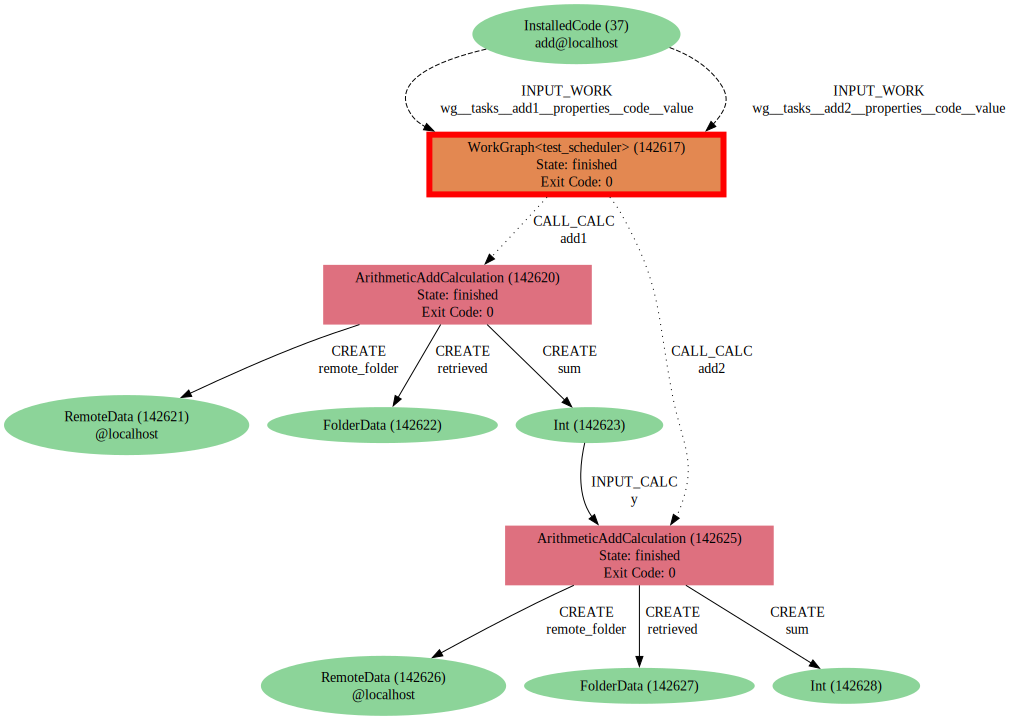

In [2]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)


## Checkpointing

The Scheduler checkpoints its status to the database whenever a WorkGraph is updated, ensuring that the Scheduler can recover its state in case of a crash or restart. This feature is particularly useful for long-running WorkGraphs.

## Conclusion

The Scheduler offers a streamlined approach to managing complex workflows, significantly reducing active process counts and improving resource efficiency.